In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_dynamics.models import (
    GeneratorModel,
    HamiltonianModel,
    LindbladModel,

    DenseOperatorCollection,
    SparseOperatorCollection,
    DenseLindbladCollection,
    DenseVectorizedLindbladCollection,
    SparseLindbladCollection,

    perform_rotating_wave_approximation,
)
from qiskit_dynamics.signals import (
    Signal,
    SignalList
)

# In This Demo

This demo presents the `operator_collections` functionality for `Model` classes, which effectively function as a calcluation object for the `Model`, so that the actual evaluation functionality of the `Model` is performed by one of its operator collection, not by the model itself. By abstracting the calculation from the `Model` itself, it is now possible to evaluate multiple modes of evaluation–e.g. using sparse matrices to store Hamiltonian components or a vectorized Lindblad evaluation mode–by simply changing an `evaluation_mode` property of the Model. This also enables future development of different evaluation modes as a simple drop-in process: simply create a new `OperatorCollection` that performs the math in the way you want and add a new supported `evaluation_mode` to the `Model` that uses this new collection.

We will also discuss the new Rotating Wave Approximation function, which functions by taking in a `Model` and returns a new `Model` with the RWA applied. 

Let us consider a simple model for a two-level-system, where we use a Hamiltonian of the form $$\mathcal{H}(t) = \omega_0\sigma_z - \Omega(t)\cos(2\pi\nu t)\sigma_x\qquad \Omega(t) = \Omega_0 e^{-t^2/2\tau^2}$$In the language of `qiskit_dynamics`, this is represented as follows:

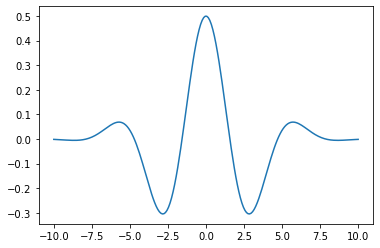

In [2]:
Omega_0 = 0.5
tau = 3
omega_0 = 1
nu = 1/(2*np.pi) #2\pi\nu = \omega_0

Omega = lambda t: Omega_0 * np.exp(-t**2/(2*tau**2))
drive_signal = Signal(Omega,nu,0)

times = np.linspace(-10,10,200)
plt.plot(times,drive_signal(times))

drive_operator = -np.array([[[0,1],[1,0]]])
drift_operator = omega_0*np.array([[1,0],[0,-1]])

model = HamiltonianModel(drive_operator,drift=drift_operator,signals=[drive_signal])

We may generically represent the Schr\"odinger equation in natural units for a state $y$ as $$\dot{y} = -iH(t)y$$`HamiltonianModel` is a model class that is intended to evaluate both $-iH$ and $-iHy$ for a given $t$ and $y$.

In [3]:
time = 0

print(model(time)) # evaluates -iH

state = np.array([0,1]) # ground state at t = \pm\infty
print(model(time,state)) # evaluates -iHy

[[0.-1.j  0.+0.5j]
 [0.+0.5j 0.+1.j ]]
[0.+0.5j 0.+1.j ]


Under the hood, the actual evaluation of the model is done by `Model._operator_collection`, which is, by default, a `DenseOperatorCollection`. All `OperatorCollection`s really do is to take in the numeric signal values and return the value of the model in a way that is as optimized for its mode of evaluation as possible. They do not know about a `Model`'s `RotatingFrame` or its actual `SignalList`, and–for the most part–are just taking linear combinations of operators, given a list of coefficients. This makes the generic evaluation process for a `Model` an extremely modular process, where each of the following steps can be modified independently and cleanly: 

\begin{enumerate}

\item Pass state to `RotatingFrame` for pre-rotation (if applicable, e.g. $|\psi\rangle\to e^{-iHt}|\psi\rangle$) and basis change (if applicable).

\item Get Signal values from `SignalList` object.

\item Pass Signal values and state (if applicable) to `OperatorCollection` to evaluate model.

\item Pass model to `Rotatingframe` for post-rotation (if applicable, e.g. $|\psi\rangle \to e^{iHt}|\psi\rangle$) and basis change (if applicable).

\end{enumerate}

In [4]:
sig_vals = model.signals(time)

print(model._operator_collection(sig_vals))

print(model._operator_collection(sig_vals,state))

[[ 1.  -0.5]
 [-0.5 -1. ]]
[-0.5 -1. ]


Because `DenseOperatorCollection`s are designed for the more general `GeneratorModel`, rather than the `HamiltonianModel` we are using, it actually evaluates the Hamiltonian $H(0)=\sigma_z-\sigma_x/2$. The `HamiltonianModel` simply multiplies this output by $-i$. 

Because the `OperatorCollection`s are such simple objects, it is a very simple process to simply add a different evaluation mode. Generically, all that needs to be done is to write a new `OperatorCollection` class that performs the math in a particular way, then to add a new possible value for the `Model` class's `evaluation_mode` that sets `Mode._operator_collection` to this new evaluation mode. 

Having simple support for multiple evaluation modes can be quite important from a user perspective. For example, when Hamiltonian components are mathematically sparse, it may make sense to store only sparse Hamiltonian components. This is accomplished through a simple property change on the user side. 

In [5]:
model.evaluation_mode = "sparse"
print(model(time))
print(model(time,state))

  (0, 0)	-1j
  (0, 1)	0.5j
  (1, 0)	0.5j
  (1, 1)	1j
[0.+0.5j 0.+1.j ]


When we bring a `Model` into the rotating frame (by providing it a `RotatingFrame` object or a\[n\] \[anti\]hermitian operator), its `OperatorCollection` is automatically transferred into the basis in which the frame operator, $F$, is diagonal: 

In [6]:
frame_op = np.array([[0,1],[1,0]])

model.evaluation_mode = "sparse"

model.frame = frame_op

# In basis in which F is diagonal, \sigma_x -> \sigma_z
print(model._operator_collection._operators[0].toarray())

print(model(time))

[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]
[[0.-1.j  0.+1.5j]
 [0.+1.5j 0.+1.j ]]


Frame setting is non-destructive–every time a new frame is set, the operators will be transformed into the new basis appropriately. Let's now go to the more useful, standard rotating frame $|\psi\rangle \to e^{iH't}|\psi\rangle $ with $H' = \omega_0\sigma_z$. Under these conditions, the effective Hamiltonisn we're dealing with is simply $\tilde H = H-H' = -\Omega(t)\cos(2\pi\nu t)\sigma_x$. At time $t=0$, then, we expect to have our RHS be $i\sigma_x=-i\tilde{H}(0)$

In [7]:
model.frame = np.array([1,-1])

print(model(time))

  (0, 1)	0.5j
  (1, 0)	0.5j


Notice that the output of the model has changed from dense to sparse when we use a diagonal frame. This is because–in general–any non-diagonal frame operator will have some complicated basis transformation to make it diagonal. This complicated basis transformation will tend to make mathematically sparse matrices into mathematically dense ones, hence removing the performance advantage. Thus, we only retain the sparse matrices when the frame is diagonal. 

We of course also have the option of adding noise/dissipator terms. Once we add these terms, however, our state evolution is best described by the Lindblad equation $$\dot\rho = -i[H,\rho]+\sum_j \gamma_j(t)\left[ L_i\rho L_i^\dagger - \frac{1}{2}\left\{L_i^\dagger L_i,\rho\right\}\right]$$In particular, let there be just one dissipator term, with $\gamma=1$ and $L = |g\rangle\langle e|$. The dissipator term of the time evolution should then read $$\dot\rho = -i[H,\rho] + \begin{pmatrix}-\rho_{ee}&\rho_{eg}/2\\\rho_{ge}/2&\rho_{ee}\end{pmatrix}$$ a nice decay of the excited state. Let's work with $\rho = |e\rangle\langle e|$

In [8]:
rho = np.diag([1,0])
dissipator_operators = np.array([[[0,0],[1,0]]]) # |g><e|
dissipator_signals = Signal(1,0,0)

dis_model = LindbladModel(drive_operator,hamiltonian_signals=[drive_signal],drift=drift_operator,dissipator_signals=[dissipator_signals],dissipator_operators=dissipator_operators)

In [9]:
dis_model(time,rho)

Array([[-1.+0.j ,  0.-0.5j],
       [ 0.+0.5j,  1.+0.j ]], backend='numpy')

Here, we can see the diagonal terms coming from the dissipation, as well as the off-diagonal, $\sigma_y$-like terms coming from the Hamiltonian contribution. This is confirmed by directly calculating the Hamiltonian: 

In [10]:
h = dis_model.evaluate_hamiltonian(time)
print(h)
print(h @ rho - rho @ h)

[[ 1.  -0.5]
 [-0.5 -1. ]]
[[ 0.   0.5]
 [-0.5  0. ]]


And of course, the same evaluation-mode setting works with dissipative models. 

This also gives a good chance to showcase vectorization, which allows us to write the Lindbladian as a simpler GeneratorModel, at the cost of larger dimension dimension (hence higher memory usage & longer computation times). This can be necessary for some solvers. One upside is that–when vectorized–we can directly evaluate the generator of the model, something that is not possible with the base `evaluation_mode=dense` mode for the LindbladModel. 

In [11]:
dis_model.evaluation_mode = "dense_vectorized"

vectorized_generator = dis_model(time)
print(vectorized_generator)
print((vectorized_generator @ rho.flatten(order="F")).reshape((2,2),order="F"))

dis_model.evaluation_mode = "sparse"
print(dis_model(time,rho))

[[-1. +0.j   0. +0.5j  0. -0.5j  0. +0.j ]
 [ 0. +0.5j -0.5+2.j   0. +0.j   0. -0.5j]
 [ 0. -0.5j  0. +0.j  -0.5-2.j   0. +0.5j]
 [ 1. +0.j   0. -0.5j  0. +0.5j  0. +0.j ]]
[[-1.+0.j   0.-0.5j]
 [ 0.+0.5j  1.+0.j ]]
[[-1.+0.j   0.-0.5j]
 [ 0.+0.5j  1.+0.j ]]


All of these evaluation modes are vectorized in the programming sense. In the case of any pure-left-multiplication evaluation mode (GeneratorModel, HamiltonianModel, and _importantly_ Vectorized LindbladModel), we evaluate multiple states simultaneously by storing them in a matrix $\Psi:\Psi_{ij}$ is the $i^{th}$ component of the $j^{th}$ state. In the case of the two other Lindbladian evaluation modes, `sparse` and `dense`, we store this as a 3-index tensor $R:R_{ijk}=(\rho_i)_{jk}$. 

In [12]:
states = np.array([[1,0],[1,1]])

model.evaluation_mode="dense"
print(np.round(model(time,states),3))
model.evaluation_mode="sparse"
print(model(time,states))

[[0.+0.5j 0.+0.5j]
 [0.+0.5j 0.-0.j ]]
[[0.+0.5j 0.+0.5j]
 [0.+0.5j 0.-0.j ]]


In [13]:
rhos = np.array([np.diag([1,0]),np.diag([0,-1])])

dis_model.evaluation_mode = "dense"
print(dis_model(time,rhos),"\n")
dis_model.evaluation_mode = "sparse"
print(dis_model(time,rhos),"\n")
dis_model.evaluation_mode = "dense_vectorized"
rhos = np.reshape(rhos,(2,4),order="F").transpose()
print(dis_model(time,rhos),"\n")

[[[-1.+0.j   0.-0.5j]
  [ 0.+0.5j  1.+0.j ]]

 [[ 0.+0.j   0.-0.5j]
  [ 0.+0.5j  0.+0.j ]]] 

[[[-1.+0.j   0.-0.5j]
  [ 0.+0.5j  1.+0.j ]]

 [[ 0.+0.j   0.-0.5j]
  [ 0.+0.5j  0.+0.j ]]] 

[[-1.+0.j   0.+0.j ]
 [ 0.+0.5j  0.+0.5j]
 [ 0.-0.5j  0.-0.5j]
 [ 1.+0.j   0.+0.j ]] 



All of these operations also work with rotating frames, as well. In the case of `GeneratorModel`/`HamiltonianModel`s, a frame transformation is of the form $y\to e^{-tF}y$; in the case of a `LindbladModel`, it is of the form $\rho\to e^{-tF}\rho e^{tF}$. 

In [14]:
model.frame = np.array([1,-1])

model.evaluation_mode = "dense"
print("Dense:\n",np.round(model(time),4))
print(np.round(model(time,state),4),"\n\nSparse:")

model.evaluation_mode = "sparse"
print(model(time)) # should be sparse matrix if frame argument is 1D (diagonal), but dense if 2D
print(np.round(model(time,state),4))

Dense:
 [[0.+0.j  0.+0.5j]
 [0.+0.5j 0.-0.j ]]
[0.+0.5j 0.-0.j ] 

Sparse:
  (0, 1)	0.5j
  (1, 0)	0.5j
[0.+0.5j 0.-0.j ]


In [15]:
dis_model.frame = np.array([1,-1])

dis_model.evaluation_mode = "dense"
print(dis_model(time,rho))
print(dis_model.evaluate_hamiltonian(time))

[[-1.+0.j   0.-0.5j]
 [ 0.+0.5j  1.+0.j ]]
[[ 0. +0.j -0.5+0.j]
 [-0.5+0.j  0. +0.j]]


In [16]:
dis_model.evaluation_mode = "sparse"
print(dis_model(time,rho))
print(dis_model.evaluate_hamiltonian(time))

[[-1.+0.j   0.-0.5j]
 [ 0.+0.5j  1.+0.j ]]
  (0, 1)	(-0.5+0j)
  (1, 0)	(-0.5+0j)


In [17]:
dis_model.evaluation_mode = "dense_vectorized"
print(dis_model(time,rho.flatten(order="F")))
print(dis_model.evaluate_hamiltonian(time))

[-1.+0.j   0.+0.5j  0.-0.5j  1.+0.j ]
[ 0. +0.j -0.5+0.j -0.5+0.j  0. +0.j]


Because we have vectorized the `LindbladModel` here, we can evaluate its generator directly, in the rotating frame, without reference to a state. Although the frame rotations (conjugation by $e^{\pm tF}$) are written in a fairly optimized manner, they are still quite slow–primarily becasue they must assign and calculate `dim^4` values for the frame transformations, rather than the `2dim^2` values if it can use the further-optimized methods for evaluation given a state. Thus, this generator evaluation method should really only be used if it needs to be used without reference to the state–evaluating it, then left-multiplying a state is much slower than the alternative. 

In [18]:
gen = dis_model.evaluate_generator(time)
print(gen @ rho.flatten("F")) # equivalent, but much slower.
print(gen)

[-1.+0.j   0.+0.5j  0.-0.5j  1.+0.j ]
[[-1. +0.j   0. +0.5j  0. -0.5j  0. +0.j ]
 [ 0. +0.5j -0.5+0.j   0. +0.j   0. -0.5j]
 [ 0. -0.5j  0. +0.j  -0.5+0.j   0. +0.5j]
 [ 1. +0.j   0. -0.5j  0. +0.5j  0. +0.j ]]


Finally, we can perform the rotating wave approximation through the function `perform_rotating_wave_approximation`, which sends `Model`$\to$`Model` types, applying the rotating wave approximation by removing all components that are rotating (in the frame) at some frequency above a `cutoff_freq`[uency]. If we expand our Hamiltonian in the rotating frame, which–as a reminder–is given by $$\tilde H(t) = e^{i\sigma_z t}(e^{-t^2/18}\sigma_x/2)e^{-i\sigma_z t}=\left(
\begin{array}{cc}
 0 & -\frac{1}{4} e^{-\frac{t^2}{18}+i t}-\frac{1}{4} e^{-\frac{t^2}{18}+3 i t} \\
 -\frac{1}{4} e^{-\frac{t^2}{18}+i t}-\frac{1}{4} e^{-\frac{t^2}{18}+3 i t} & 0 \\
\end{array}
\right)$$

we can readily observe that there are terms with frequency of magnitude $3/2\pi$ and $1/2\pi$. If we set a cutoff frequency of $1/\pi$, then, we expect that we will be left only with the $e^{\pm it}$ terms. 

`perform_rotating_wave_approximation` functions by effectively adding redundant terms to our Hamiltonian/Dissipator terms that incorporate the frequency-filtering behavior we want, so it can increase memory use by about a factor of two over the original model, so it is important to use it carefully. With that said, it is a very useful functionality. 

In [19]:
new_model,f=perform_rotating_wave_approximation(model,1/np.pi)
new_model.evaluation_mode="dense"
print(np.round(new_model(time),3))
new_model.evaluation_mode="sparse"
print(np.round(new_model(time),3))

[[-0.-0.j    0.+0.25j]
 [-0.+0.25j  0.-0.j  ]]
  (1, 0)	(-0+0.25j)
  (0, 1)	0.25j


The function $f$ that is also passed by the RWA function is intended to make setting Signal values easier. In particular, becasue of the way that `perform_rotating_wave_approximation` works, we need a map that takes `SignalList`$\to$`SignalList`, so that the user only needs to specify signals in the way they would to the pre-RWA model; passing them through $f$ will then convert them to the necessary post-RWA format.

It is important to note that changing the frequencies by setting new `Signal` objects could make the RWA invalid calculation at the new `Signal` values. Thus, changing the signals should be done only when it's certain that the new frequencies will not invalidate the RWA calculations. 

In [20]:
# add a pi/2 phase shift
new_model.signals = f([Signal(Omega,nu,np.pi/2)])

print(np.round(new_model(time),3))

  (1, 0)	(-0.25+0j)
  (0, 1)	(0.25+0j)


We can also perform the RWA on `LindbladModel`s. Because of the more complicated and second-order dependence on the dissipator terms $L_i$, however, it's not as straightforward as the Hamiltonian case. In particular, it is difficult to represent the RWA as a simple map between collections of dissipators, $\{L_i\}\to\{L_j'\}$–possibly impossible without more than doubling the memory usage. Currently, the RWA functionality treates dissipator terms exactly as it treats Hamiltonian terms, which should mean that–for the most part–it may be a more strong approximation for the dissipator terms. 

In [21]:
dis_model.evaluation_mode="dense"
new_dis_model,f=perform_rotating_wave_approximation(dis_model,1/np.pi)
print(np.round(new_dis_model.evaluate_hamiltonian(time),3))
print(np.round(new_dis_model(time,rho),3))

[[ 0.  +0.j -0.25+0.j]
 [-0.25-0.j  0.  +0.j]]
[[ 0.+0.j   -0.-0.25j]
 [-0.+0.25j  0.+0.j  ]]


Note that our dissipator term has been removed, despite seeming to be time-invariant. This is due to the way to the perhaps-needlessly-stringent RWA functionality. In particular, becasue we set $L=|g\rangle\langle e|$ with no associated frequency ($\gamma = 1$), and because our frame effectively introduces a frequency of $\pm 1/\pi$ on the two off-diagonal entries, the dissipator terms are just past the threshold for being pruned. If we use even a marginally smaller cutoff, we'll get back the dissipator terms: 

In [22]:
dis_model.evaluation_mode="sparse"
new_dis_model,f=perform_rotating_wave_approximation(dis_model,1.001/np.pi)
print(np.round(new_dis_model.evaluate_hamiltonian(time),3))
print(np.round(new_dis_model(time,rho),3))

  (1, 0)	(-0.25-0j)
  (0, 1)	(-0.25+0j)
[[-1.+0.j   -0.-0.25j]
 [-0.+0.25j  1.+0.j  ]]


# Takeaways: 

1. `OperatorCollection`s provide a modular way for `Model` classes to use and easily switch between different evaluation modes. 
    
    a. Easier to implement new evaluation modes without cluttering every `Model` class
    
    b. Allows `Models` to work in four steps, each of which is modular and separated from the main `Model` implementation. 


2. Rotating Wave Approximation is now handled by a function mapping `Model` classes to other `Model` classes

    a. Clearer interface on the user side with easy signal handling for translating pre-RWA to post-RWA. 

    b. Core functionality is implmented in helper functions, which makes future RWA implementations easier

    c. Most of the `perform_rotating_wave_approximation` function is simply casework to determine which type of model it is 
        dealing with, along with a smal bit of special handling for each `Model` class. This makes adding new `Model` classes
        relatively straightforward. 


3. Additional features added over the past few weeks

    a. Non-vectorized `LindbladModel` evaluation and `RotatingFrame` support for `LindbladModel`s. 

    b. Basic sparse matrix operator storage and calculation (`csr_matrix`)

    c. Rotating frames & basis transformations for vectorized evaluation are implemented in a manner that's simpler to the user 
        (e.g. passing only $F$, and the `Frame` object figuring out how to deal with vectorized operators).

    d. Diagonal frame operators no longer waste time changing bases. 

    e. Optimizations to speed in a few existing places, as well as several rounds of optimization within `OperatorCollection`s.

    f. `evaluate_hamiltonian` functionality for `LindbladModel`